This kernel is a mere copy from https://www.kaggle.com/tuckerarrants/openvaccine-gru-lstm, my only contribution is to show how much the scoring is affected by training only on "signal_to_noise" levels higher than 1.

# Section 1: Project Definition

**In this [new competition](https://www.kaggle.com/c/stanford-covid-vaccine/overview) we are helping to fight against the worldwide pandemic COVID-19. mRNA vaccines are the fastest vaccine candidates to treat COVID-19 but they currently facing several limitations. In particular, it is a challenge to design stable messenger RNA molecules. Typical vaccines are packaged in syringes and shipped under refrigeration around the world, but that is not possible for mRNA vaccines (currently).**

**Researches have noticed that RNA molecules tend to spontaneously degrade, which is highly problematic because a single cut can render mRNA vaccines useless. Not much is known about which part of the backbone of a particular RNA is most susceptible to being damaged.**

**Without this knowledge, the current mRNA vaccines are shopped under intense refrigeration and are unlikely to reach enough humans unless they can be stabilized. This is our task as Kagglers: we must create a model to predict the most likely degradation rates at each base of an RNA molecule.**

**We are given a subset of an Eterna dataset comprised of over 3000 RNA molecules and their degradation rates at each position. Our models are then tested on the new generation of RNA sequences that were just created by Eterna players for COVID-19 mRNA vaccines**

# Section 2 : Analysis

## Libraries and Installations

In [2]:
import warnings
warnings.filterwarnings('ignore')

#the basics
import pandas as pd, numpy as np
import math, json, gc, random, os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm

#tensorflow deep learning basics
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import LSTM


#for model evaluation
from sklearn.model_selection import train_test_split, KFold


print("set up complete!")

set up complete!


### Loading the data

In [3]:
#get comp data
train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)
sample_sub = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')


print ("Data Load Complete")

Data Load Complete


### Exploring the data

In [4]:
#sneak peak
print(train.shape)
if ~ train.isnull().values.any(): print('No missing values')
train.head()

(2400, 19)
No missing values


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [5]:
#sneak peak
print(test.shape)
if ~ test.isnull().values.any(): print('No missing values')
test.head()

(3634, 7)
No missing values


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [9]:
#sneak peak
print(sample_sub.shape)
if ~ sample_sub.isnull().values.any(): print('No missing values')
sample_sub.head()

(457953, 6)
No missing values


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


### Columns and their definition

**From the data [description tab](https://www.kaggle.com/c/stanford-covid-vaccine/data), we must predict multiple ground truths in this competition, 5 to be exact. While the submission requires all 5, only 3 are scored: `reactivity`, `deg_Mg_pH10` and `deg_Mg_50C`**

**The training features we are given are as follows:**

* **id** - An arbitrary identifier for each sample.
* **seq_scored** - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of `reactivity`, `deg_*` and `*_error_*` columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* **seq_length** - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of `sequence`. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* **sequence** - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of `A`, `G`, `U`, and `C` for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in `seq_scored` (note: indexed starting at 0).
* **structure** - (1x107 string in Train and Public Test, 130 in Private Test) An array of `(`, `)`, and `.` characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.
* **reactivity** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likely secondary structure of the RNA sample.
* **deg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).
* **deg_Mg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).
* **deg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).
* **deg_Mg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).
* **`*_error_*`** - An array of floating point numbers, should have the same length as the corresponding `reactivity` or `deg_*` columns, calculated errors in experimental values obtained in `reactivity` and `deg_*` columns.
* **predicted_loop_type** - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in `sequence`. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

# Section 3: Methodology

## Data Preprocessing

In [6]:
# We have errors for the scored metrics (reactivity, deg_Mg_pH10 and deg_Mg_50C), using the errors and actual values we want to create pseudo target variables

def add_list(test_list1, test_list2):
    '''Function to take two lists and add the elemnets of them together
       Input : list 1 and list 2
       Output: list 3 with each element as the sum of the input lists'''
    res_list = [] 
    for i in range(0, len(test_list1)): 
        res_list.append(test_list1[i] + test_list2[i])
    return res_list

def subtract_list(test_list1, test_list2):
    '''Function to take two lists and subtract the elemnets of list 2 from list 1
       Input : list 1 and list 2
       Output: list 3 with each element as list 2 elemnets subtracted from list 1 elements'''
    res_list = [] 
    for i in range(0, len(test_list1)): 
        res_list.append(test_list1[i] - test_list2[i])
    return res_list

In [7]:
#Create additional target features

#adding the errors - this will overpredict the target variables
train['reactivity_over'] = train.apply(lambda x: add_list(x.reactivity,x.reactivity_error), axis=1)
train['deg_Mg_pH10_over'] = train.apply(lambda x: add_list(x.deg_Mg_pH10,x.deg_error_Mg_pH10), axis=1)
train['deg_pH10_over'] = train.apply(lambda x: add_list(x.deg_pH10,x.deg_error_pH10), axis=1)
train['deg_Mg_50C_over'] = train.apply(lambda x: add_list(x.deg_Mg_50C,x.deg_error_Mg_50C), axis=1)
train['deg_50C_over'] = train.apply(lambda x: add_list(x.deg_50C,x.deg_error_50C), axis=1)

#subtracting the errors - this will underpredict the target variables
train['reactivity_under'] = train.apply(lambda x: subtract_list(x.reactivity,x.reactivity_error), axis=1)
train['deg_Mg_pH10_under'] = train.apply(lambda x: subtract_list(x.deg_Mg_pH10,x.deg_error_Mg_pH10), axis=1)
train['deg_pH10_under'] = train.apply(lambda x: subtract_list(x.deg_pH10,x.deg_error_pH10), axis=1)
train['deg_Mg_50C_under'] = train.apply(lambda x: subtract_list(x.deg_Mg_50C,x.deg_error_Mg_50C), axis=1)
train['deg_50C_under'] = train.apply(lambda x: subtract_list(x.deg_50C,x.deg_error_50C), axis=1)

print ("Additional target variables created!")

Additional target variables created!


In [8]:
# looking at train data with additional target variables
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,reactivity_over,deg_Mg_pH10_over,deg_pH10_over,deg_Mg_50C_over,deg_50C_over,reactivity_under,deg_Mg_pH10_under,deg_pH10_under,deg_Mg_50C_under,deg_50C_under
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.4656, 1.7763000000000002, 1.286, 1.0138, 0....","[1.0169000000000001, 3.3672, 0.389800000000000...","[2.6006, 3.7920000000000003, 0.3972, 1.1682, 0...","[0.5082, 3.2433, 0.3536, 1.6418000000000001, 0...","[0.8549, 3.8248, 1.1868, 1.5352, 0.95800000000...","[0.1938, 1.3623, 0.9594, 0.7234, 0.5903, 0.333...","[0.4943, 2.5988, 0.11539999999999997, 1.1258, ...","[2.0744, 3.22, 0.20440000000000003, 0.85339999...","[0.20800000000000002, 2.6933000000000002, 0.16...","[0.4215, 3.1298, 0.8108, 1.1104, 0.61740000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,"[2.8272, 2.8272, 2.8272, 7.0308, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[15.145600000000002, 13.694099999999999, 5.093...","[21.4685, 17.910600000000002, 8.1968, 8.1968, ...","[23.154899999999998, 7.9596, 24.35179999999999...","[-2.8272, -2.8272, -2.8272, -2.4378, -2.5676, ...","[-73705.3985, -73705.3985, -73705.3985, -73705...","[-5.251600000000001, -4.789499999999999, -5.09...","[-11.766300000000001, -9.8254, -8.1968, -8.196...","[-7.8165, -7.9596, -2.4396000000000004, -5.877..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.5413, 1.6151, 1.2947, 0.8325, 0.7992, 0.733...","[0.3869, 1.6258, 1.1616, 0.63, 0.4801, 1.0575,...","[2.4132, 3.1141, 1.1663, 0.8119999999999999, 0...","[0.6195999999999999, 1.8287000000000002, 1.155...","[1.0999, 1.9735999999999998, 1.6508, 0.9853000...","[0.3551, 1.3493, 1.0691, 0.6543000000000001, 0...","[0.1139, 1.1784, 0.7992, 0.36340000000000006, ...","[2.0728, 2.7581, 0.9442999999999999, 0.63, 0.5...","[0.413, 1.5359, 0.9299999999999999, 0.694, 0.6...","[0.8003, 1.6214, 1.3474000000000002, 0.7519, 0..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,"[3.5229, 8.3147, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73704.8902, 73705.3985, 73705.398...","[15.2255, 19.5694, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121285.8817, 121286.7181, 121286...","[23.0687, 6.790099999999999, 7.7824, 7.7824, 7...","[-3.5229, -3.8348999999999998, -3.0374, -3.037...","[-73705.3985, -73705.9068, -73705.3985, -73705...","[-8.375900000000001, -5.9438, -5.7733, -5.7733...","[-121286.7181, -121287.55470000001, -121286.71...","[-7.7303, -9.4347, -7.7824, -7.7824, -7.7824, ..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,"[2.4917, 4.830500000000001, 4.8522, 1.6414, 0....","[6.319699999999999, 7.1017, 5.7904, 3.5648, 1....","[7.8308, 7.6393, 3.3280000000000003, 3.209, 0....","[4.8769, 4.2765, 2.7376, 5.671799999999999, 2....","[1.3285, 8.7371, 0.9506000000000001, 0.9503, 1...","[-0.8383, 0.4849000000000001, 0.84399999999999...","[-2.1081, -0.8257000000000003, -0.702999999999...","[1.6424000000000003, 1.6092999999999997, -0.91...","[-0.4664999999999999, -0.6870999999999

In [10]:
#target columns
target_cols_actual = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
target_cols_over = ['reactivity_over', 'deg_Mg_pH10_over', 'deg_pH10_over', 'deg_Mg_50C_over', 'deg_50C_over']
target_cols_under = ['reactivity_under', 'deg_Mg_pH10_under', 'deg_pH10_under', 'deg_Mg_50C_under', 'deg_50C_under']

In [12]:
# Now we create a dictionary to help us map sequence, structure, and predicted_loop_type to columns we can feed a model:

token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

In [13]:
cols=['sequence', 'structure', 'predicted_loop_type']
train[cols].applymap(lambda seq: [token2int[x] for x in seq])

,sequence,structure,predicted_loop_type
0,"[5, 5, 3, 3, 3, 3, 5, 4, 6, 4, 6, 3, 3, 6, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 9, 9, ..."
1,"[5, 5, 3, 3, 3, 3, 3, 5, 4, 5, 4, 5, 4, 5, 4, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12..."
2,"[5, 5, 3, 3, 3, 5, 6, 5, 4, 6, 4, 3, 5, 3, 6, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 10, 12, 12, 10..."
3,"[5, 5, 3, 3, 3, 3, 5, 4, 5, 4, 5, 4, 5, 4, 5, ...","[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12,..."
4,"[5, 5, 3, 3, 3, 3, 6, 3, 6, 3, 6, 3, 3, 6, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 7,..."
...,...,...,...
2395,"[5, 5, 3, 3, 3, 3, 6, 3, 5, 4, 3, 5, 3, 5, 5, ...","[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, ...","[8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 10, 10, 12, 1..."
2396,"[5, 5, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
2397,"[5, 5, 3, 3, 3, 5, 4, 4, 3, 6, 3, 4, 4, 6, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12..."
2398,"[5, 5, 3, 3, 3, 4, 5, 3, 6, 3, 5, 4, 3, 5, 3, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, ...","[8, 8, 8, 8, 8, 12, 12, 12, 12, 10, 10, 12, 9,..."


In [14]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    ''' Creating a function that takes a dataset and n categorical input columns of the dataset and creates a n dimensional array using the tokenizer created above
        Input : Dataframe, Categorical columns
        Output: n dimentional array where n # of columns'''
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )


In [15]:
# preparing Input and Target variables
train_inputs = preprocess_inputs(train[train.signal_to_noise > 1])
train_y_actual = np.array(train[train.signal_to_noise > 1][target_cols_actual].values.tolist()).transpose((0, 2, 1))
train_y_over = np.array(train[train.signal_to_noise > 1][target_cols_over].values.tolist()).transpose((0, 2, 1))
train_y_under = np.array(train[train.signal_to_noise > 1][target_cols_under].values.tolist()).transpose((0, 2, 1))

In [16]:
#check shapes of the preprocessed inputs (it has to be in the form - (samples, timesteps, features))
print (train_inputs.shape)
print (train_y_actual.shape)
print (train_y_over.shape)
print (train_y_under.shape)

(2096, 107, 3)
(2096, 68, 5)
(2096, 68, 5)
(2096, 68, 5)


In [17]:
# type of data

print (type(train_inputs))
print (type(train_y_actual))
print (type(train_y_over))
print (type(train_y_under))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Section 4: Modelling and Results

**We begin with a simple GRU model taken from the one and only [Xhlulu](https://www.kaggle.com/xhlulu)'s notebook [here](https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model)**

**From the documentation of this competition, you can read that due to technical reasons, measurements cannot be carried out on the final bases of the RNA sequences we have just have experimental data (as ground truths) in 5 conditions for the first 68 bases. This means we must truncate the output of our model:**

In [18]:
# Defining components of our model
inputs = tf.keras.layers.Input(shape=(107, 3))
embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=75)(inputs)
reshaped = tf.reshape(
        embed, shape=(embed.shape[1],  embed.shape[2] * embed.shape[3]))
# here too - we are reshaping the tensor as samples (which can be 1 at a time so no need to specify, 3*75 features for each of the time steps)

In [19]:
# Creating functions for our models
def gru_layer(hidden_dim, dropout):
    ''' Using the hidden_dim and dropout parameters given this function will return a parametrized gru layer
        input : parameters of the layer
        output : gru layer : '''
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    ''' Using the hidden_dim and dropout parameters given this function will return a parametrized LSTM layer
        input : parameters of the layer
        output : LSTM layer : '''
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def build_model(gru=False,seq_len=107, pred_len=68, dropout=0.5,
                embed_dim=100, hidden_dim=128):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    if gru:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    else:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
    
    #only making predictions on the first part of each sequence
    dense_layer_1 = tf.keras.layers.Dense(100, activation = 'linear')(hidden)
    dense_layer_2 = tf.keras.layers.Dense(50, activation = 'linear')(dense_layer_1)
    dropout_layer = tf.keras.layers.Dropout(dropout)(dense_layer_2)
    truncated = hidden[:, :pred_len]
    
    out = tf.keras.layers.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    #some optimizers
    adam = tf.optimizers.Adam(learning_rate = 0.01, decay = 0.0001)
    radam = tfa.optimizers.RectifiedAdam()
    lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    model.compile(optimizer = adam, loss='mse')
    
    return model

print ("Model structure defined")

Model structure defined


In [20]:
#designing an LSTM


def lstm_model (seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68):
    
    ''' Using the paramets this function will return a fully built LSTM network
        Inputs : model parameters
        Output : LSTM model'''
    
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=output_dim)(inputs)
    reshaped = tf.keras.layers.Reshape((seq_len,3*output_dim), input_shape=(seq_len, 3, output_dim))(embed)
    


    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (128,  dropout = dropout,kernel_initializer = 'orthogonal', return_sequences = True ))(reshaped)
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (128,  dropout = dropout,kernel_initializer = 'orthogonal', return_sequences = True ))(hidden)
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (128,  dropout = dropout,kernel_initializer = 'orthogonal', return_sequences = True ))(hidden)
    dense_layer_1 = tf.keras.layers.Dense(100, activation = 'linear')(hidden)
    dense_layer_2 = tf.keras.layers.Dense(50, activation = 'linear')(dense_layer_1)
    dropout_layer = tf.keras.layers.Dropout(dropout)(dense_layer_2)
    
    truncated = dropout_layer[:,:pred_len]
    output = tf.keras.layers.Dense(5, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)

    adam = tf.optimizers.Adam(learning_rate = 0.01, decay = 0.0001)

    model.compile(loss='mse',
                optimizer= adam ,
                )
    return model




### Training

**Create train/val split now so both models are trained and evaluated on the same samples:**

In [21]:
# preparing data for simple LSTM and GRU
train_data, val_data, train_labels, val_labels = train_test_split(train_inputs, train_y_actual,
                                                                     test_size=.2, random_state=4)

# preparing data for simple LSTM - over prediction
train_data_over, val_data_over, train_labels_over, val_labels_over = train_test_split(train_inputs, train_y_over,
                                                                     test_size=.2, random_state=4)

# preparing data for simple LSTM - under prediction
train_data_under, val_data_under, train_labels_under, val_labels_under = train_test_split(train_inputs, train_y_under,
                                                                     test_size=.2, random_state=4)

**We will use a simple learning rate callback for now:**

In [23]:
# We will use a simple learning rate callback for now
lr_callback = tf.keras.callbacks.ReduceLROnPlateau()

### 1. Simple LSTM - actual 

In [25]:
# bulding simple LSTM
smpl_lstm_actual = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68)
sv_smpl_lstm_actual = tf.keras.callbacks.ModelCheckpoint('model_smpl_lstm_actual.h5')

In [26]:
smpl_lstm_actual.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 107, 3, 100)       1400      
_________________________________________________________________
reshape_1 (Reshape)          (None, 107, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 107, 256)          439296    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 107, 256)          394240    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 107, 256)          394240    
_________________________________________________________________
dense_3 (Dense)              (None, 107, 100)         

In [27]:
# Training the simple LSTM
history_smpl_lstm_actual = smpl_lstm_actual.fit(
    train_data, train_labels, 
    validation_data=(val_data,val_labels),
    batch_size=64,
    epochs=90,
    callbacks=[lr_callback,sv_smpl_lstm_actual],
    verbose = 2
)

print(f"Min training loss={min(history_smpl_lstm_actual.history['loss'])}, min validation loss={min(history_smpl_lstm_actual.history['val_loss'])}")

Epoch 1/90
27/27 - 3s - loss: 0.5181 - val_loss: 0.2442
Epoch 2/90
27/27 - 2s - loss: 0.2188 - val_loss: 0.1703
Epoch 3/90
27/27 - 2s - loss: 0.1791 - val_loss: 0.1536
Epoch 4/90
27/27 - 2s - loss: 0.1613 - val_loss: 0.1484
Epoch 5/90
27/27 - 2s - loss: 0.1529 - val_loss: 0.1392
Epoch 6/90
27/27 - 2s - loss: 0.1476 - val_loss: 0.1400
Epoch 7/90
27/27 - 2s - loss: 0.1437 - val_loss: 0.1329
Epoch 8/90
27/27 - 2s - loss: 0.1410 - val_loss: 0.1315
Epoch 9/90
27/27 - 2s - loss: 0.1354 - val_loss: 0.1242
Epoch 10/90
27/27 - 2s - loss: 0.1298 - val_loss: 0.1194
Epoch 11/90
27/27 - 2s - loss: 0.1260 - val_loss: 0.1271
Epoch 12/90
27/27 - 2s - loss: 0.1222 - val_loss: 0.1117
Epoch 13/90
27/27 - 2s - loss: 0.1182 - val_loss: 0.1115
Epoch 14/90
27/27 - 2s - loss: 0.1178 - val_loss: 0.1055
Epoch 15/90
27/27 - 2s - loss: 0.1110 - val_loss: 0.1039
Epoch 16/90
27/27 - 2s - loss: 0.1070 - val_loss: 0.0991
Epoch 17/90
27/27 - 2s - loss: 0.1059 - val_loss: 0.1030
Epoch 18/90
27/27 - 2s - loss: 0.1028 - 

### LSTM - over prediction

In [41]:
# Designing over prediction LSTM
smpl_lstm_over = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68)
sv_smpl_lstm_over = tf.keras.callbacks.ModelCheckpoint('model_smpl_lstm_over.h5')

In [42]:
# Training over prediction LSTM 
history_smpl_lstm_over = smpl_lstm_over.fit(
    train_data_over, train_labels_over, 
    validation_data=(val_data_over,val_labels_over),
    batch_size=64,
    epochs=80,
    callbacks=[lr_callback,sv_smpl_lstm_over],
    verbose = 2
)

print(f"Min training loss={min(history_smpl_lstm_over.history['loss'])}, min validation loss={min(history_smpl_lstm_over.history['val_loss'])}")

Epoch 1/80
27/27 - 3s - loss: 0.8351 - val_loss: 0.2821
Epoch 2/80
27/27 - 2s - loss: 0.4125 - val_loss: 0.2504
Epoch 3/80
27/27 - 2s - loss: 0.2676 - val_loss: 0.2143
Epoch 4/80
27/27 - 2s - loss: 0.2342 - val_loss: 0.2051
Epoch 5/80
27/27 - 2s - loss: 0.2135 - val_loss: 0.1907
Epoch 6/80
27/27 - 2s - loss: 0.2033 - val_loss: 0.2001
Epoch 7/80
27/27 - 2s - loss: 0.1971 - val_loss: 0.1791
Epoch 8/80
27/27 - 2s - loss: 0.1898 - val_loss: 0.1741
Epoch 9/80
27/27 - 2s - loss: 0.1851 - val_loss: 0.1811
Epoch 10/80
27/27 - 2s - loss: 0.1786 - val_loss: 0.1648
Epoch 11/80
27/27 - 2s - loss: 0.1751 - val_loss: 0.1618
Epoch 12/80
27/27 - 2s - loss: 0.1727 - val_loss: 0.1594
Epoch 13/80
27/27 - 2s - loss: 0.1686 - val_loss: 0.1605
Epoch 14/80
27/27 - 2s - loss: 0.1670 - val_loss: 0.1690
Epoch 15/80
27/27 - 2s - loss: 0.1642 - val_loss: 0.1509
Epoch 16/80
27/27 - 2s - loss: 0.1596 - val_loss: 0.1539
Epoch 17/80
27/27 - 2s - loss: 0.1593 - val_loss: 0.1603
Epoch 18/80
27/27 - 2s - loss: 0.1581 - 

### LSTM - under prediction

In [31]:
# Designing under prediction LSTM
smpl_lstm_under = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 68)
sv_smpl_lstm_under = tf.keras.callbacks.ModelCheckpoint('model_smpl_lstm_under.h5')

In [32]:
# Training under prediction LSTM
history_smpl_lstm_under = smpl_lstm_under.fit(
    train_data_under, train_labels_under, 
    validation_data=(val_data_under,val_labels_under),
    batch_size=64,
    epochs=80,
    callbacks=[lr_callback,sv_smpl_lstm_under],
    verbose = 2
)

print(f"Min training loss={min(history_smpl_lstm_under.history['loss'])}, min validation loss={min(history_smpl_lstm_under.history['val_loss'])}")

Epoch 1/80
27/27 - 3s - loss: 0.6946 - val_loss: 0.2089
Epoch 2/80
27/27 - 2s - loss: 0.2048 - val_loss: 0.1633
Epoch 3/80
27/27 - 2s - loss: 0.1726 - val_loss: 0.1505
Epoch 4/80
27/27 - 2s - loss: 0.1579 - val_loss: 0.1421
Epoch 5/80
27/27 - 2s - loss: 0.1481 - val_loss: 0.1425
Epoch 6/80
27/27 - 2s - loss: 0.1408 - val_loss: 0.1270
Epoch 7/80
27/27 - 2s - loss: 0.1330 - val_loss: 0.1218
Epoch 8/80
27/27 - 2s - loss: 0.1293 - val_loss: 0.1193
Epoch 9/80
27/27 - 2s - loss: 0.1269 - val_loss: 0.1183
Epoch 10/80
27/27 - 2s - loss: 0.1249 - val_loss: 0.1143
Epoch 11/80
27/27 - 2s - loss: 0.1201 - val_loss: 0.1099
Epoch 12/80
27/27 - 2s - loss: 0.1158 - val_loss: 0.1071
Epoch 13/80
27/27 - 2s - loss: 0.1120 - val_loss: 0.1014
Epoch 14/80
27/27 - 2s - loss: 0.1077 - val_loss: 0.0988
Epoch 15/80
27/27 - 2s - loss: 0.1050 - val_loss: 0.0945
Epoch 16/80
27/27 - 2s - loss: 0.1044 - val_loss: 0.0948
Epoch 17/80
27/27 - 2s - loss: 0.1030 - val_loss: 0.0982
Epoch 18/80
27/27 - 2s - loss: 0.0999 - 

### 2. GRU

In [33]:
# building GRU
gru = build_model(gru=True)
sv_gru = tf.keras.callbacks.ModelCheckpoint('model_gru.h5')

In [34]:
gru.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 107, 3, 100)       1400      
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 107, 300)]        0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 107, 300)          0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 107, 256)          330240    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 107, 256)          296448    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 107, 256)        

In [35]:
# Training GRU

history_gru = gru.fit(
    train_data, train_labels, 
    validation_data=(val_data,val_labels),
    batch_size=64,
    epochs=75,
    callbacks=[lr_callback,sv_gru],
    verbose = 2
)

print(f"Min training loss={min(history_gru.history['loss'])}, min validation loss={min(history_gru.history['val_loss'])}")

Epoch 1/75
27/27 - 3s - loss: 0.6891 - val_loss: 0.2186
Epoch 2/75
27/27 - 1s - loss: 0.1920 - val_loss: 0.1672
Epoch 3/75
27/27 - 1s - loss: 0.1629 - val_loss: 0.1520
Epoch 4/75
27/27 - 1s - loss: 0.1456 - val_loss: 0.1352
Epoch 5/75
27/27 - 1s - loss: 0.1363 - val_loss: 0.1294
Epoch 6/75
27/27 - 1s - loss: 0.1308 - val_loss: 0.1241
Epoch 7/75
27/27 - 1s - loss: 0.1245 - val_loss: 0.1193
Epoch 8/75
27/27 - 1s - loss: 0.1198 - val_loss: 0.1145
Epoch 9/75
27/27 - 1s - loss: 0.1159 - val_loss: 0.1100
Epoch 10/75
27/27 - 1s - loss: 0.1116 - val_loss: 0.1091
Epoch 11/75
27/27 - 1s - loss: 0.1102 - val_loss: 0.1052
Epoch 12/75
27/27 - 1s - loss: 0.1058 - val_loss: 0.1005
Epoch 13/75
27/27 - 1s - loss: 0.1020 - val_loss: 0.1031
Epoch 14/75
27/27 - 1s - loss: 0.0995 - val_loss: 0.0967
Epoch 15/75
27/27 - 1s - loss: 0.0970 - val_loss: 0.0942
Epoch 16/75
27/27 - 1s - loss: 0.0939 - val_loss: 0.0913
Epoch 17/75
27/27 - 1s - loss: 0.0909 - val_loss: 0.0919
Epoch 18/75
27/27 - 1s - loss: 0.0900 - 

# Model Evaluation

Text(0.5, 0, 'Epoch')

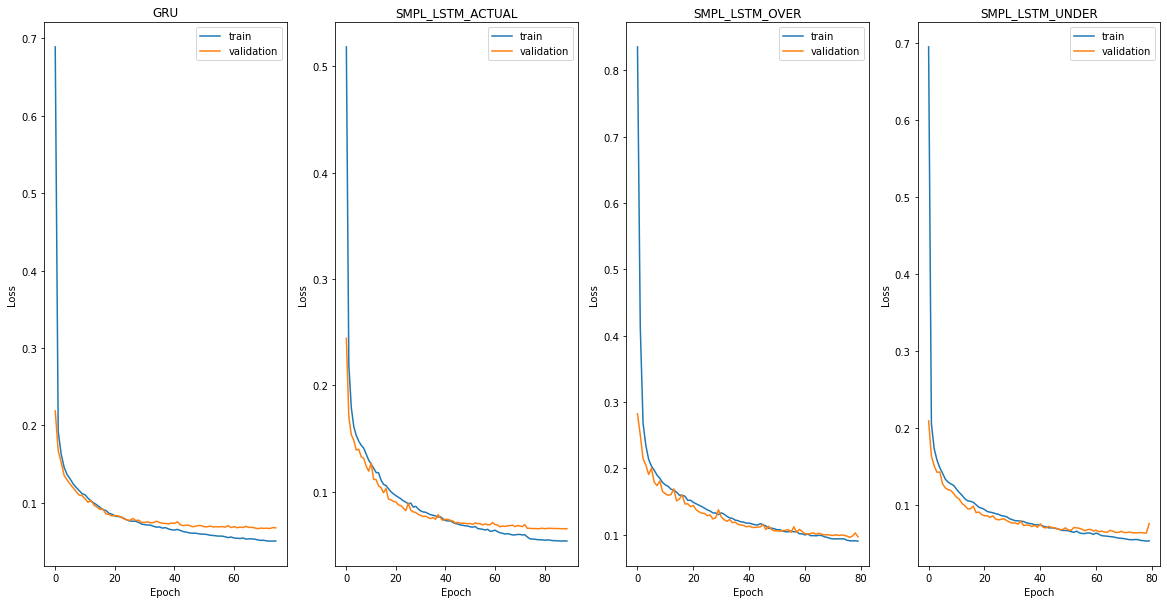

In [43]:
fig, ax = plt.subplots(1, 4,  figsize = (20, 10))

ax[0].plot(history_gru.history['loss'])
ax[0].plot(history_gru.history['val_loss'])

ax[1].plot(history_smpl_lstm_actual.history['loss'])
ax[1].plot(history_smpl_lstm_actual.history['val_loss'])

ax[2].plot(history_smpl_lstm_over.history['loss'])
ax[2].plot(history_smpl_lstm_over.history['val_loss'])

ax[3].plot(history_smpl_lstm_under.history['loss'])
ax[3].plot(history_smpl_lstm_under.history['val_loss'])

ax[0].set_title('GRU')
ax[1].set_title('SMPL_LSTM_ACTUAL')
ax[2].set_title('SMPL_LSTM_OVER')
ax[3].set_title('SMPL_LSTM_UNDER')

ax[0].legend(['train', 'validation'], loc = 'upper right')
ax[1].legend(['train', 'validation'], loc = 'upper right')
ax[2].legend(['train', 'validation'], loc = 'upper right')
ax[3].legend(['train', 'validation'], loc = 'upper right')

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_xlabel('Epoch')


### There are a couple of observations to make here
1. With rising epochs training loss is still decreasing
2. With rising epochs validation loss though seems to have stabilized with very little loss gain

This basically hints to have hit a good enough epoch range which allows us to train our model sufficiently without overfitting to the train data

# 5. Submission

In [45]:
# Preprocessing test data
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df )

print ("Test data prepared!")

Test data prepared!


**Predict twice, one for the public leaderboard, the other for the private leaderboard:**

In [47]:
#build all models
gru_short = build_model(gru=True, seq_len=107, pred_len=107)
gru_long = build_model(gru=True, seq_len=130, pred_len=130)
lstm_short_actual = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 107)
lstm_long_actual = lstm_model(seq_len = 130,output_dim = 100,dropout = 0.5, pred_len = 130)
lstm_short_over = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 107)
lstm_long_over = lstm_model(seq_len = 130,output_dim = 100,dropout = 0.5, pred_len = 130)
lstm_short_under = lstm_model(seq_len = 107,output_dim = 100,dropout = 0.5, pred_len = 107)
lstm_long_under = lstm_model(seq_len = 130,output_dim = 100,dropout = 0.5, pred_len = 130)

#load pre-trained model weights
gru_short.load_weights('model_gru.h5')
gru_long.load_weights('model_gru.h5')
lstm_short_actual.load_weights('model_smpl_lstm_actual.h5')
lstm_long_actual.load_weights('model_smpl_lstm_actual.h5')
lstm_short_over.load_weights('model_smpl_lstm_over.h5')
lstm_long_over.load_weights('model_smpl_lstm_over.h5')
lstm_short_under.load_weights('model_smpl_lstm_under.h5')
lstm_long_under.load_weights('model_smpl_lstm_under.h5')

print ("models built and trained")

models built and trained


In [48]:
#and predict
gru_public_preds = gru_short.predict(public_inputs)
gru_private_preds = gru_long.predict(private_inputs)
lstm_public_actual_preds = lstm_short_actual.predict(public_inputs)
lstm_private_actual_preds = lstm_long_actual.predict(private_inputs)
lstm_public_over_preds = lstm_short_over.predict(public_inputs)
lstm_private_over_preds = lstm_long_over.predict(private_inputs)
lstm_public_under_preds = lstm_short_under.predict(public_inputs)
lstm_private_under_preds = lstm_long_under.predict(private_inputs)

In [49]:
# Now we just need to change the shape of each sample to the long format:
preds_gru = []

for df, preds in [(public_df, gru_public_preds), (private_df, gru_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_actual)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_gru.append(single_df)

preds_gru_df = pd.concat(preds_gru)
preds_gru_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.638391,0.662310,1.987531,0.468383,0.597972,id_00073f8be_0
1,1.979713,3.073078,3.988459,3.155520,2.717483,id_00073f8be_1
2,1.186572,0.396156,0.487968,0.427016,0.596963,id_00073f8be_2
3,1.214931,1.198339,1.212393,1.729564,1.666007,id_00073f8be_3
4,0.837151,0.574181,0.624811,0.833946,0.874114,id_00073f8be_4


In [50]:
# Now we do the same for the LSTM model so we can blend their predictions:
preds_lstm_actual = []

for df, preds in [(public_df, lstm_public_actual_preds), (private_df, lstm_private_actual_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_actual)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm_actual.append(single_df)

preds_lstm_actual_df = pd.concat(preds_lstm_actual)
preds_lstm_actual_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.620086,0.683793,1.917125,0.607170,0.756090,id_00073f8be_0
1,1.956206,2.913901,3.899455,3.046923,2.701465,id_00073f8be_1
2,1.300056,0.540951,0.690854,0.656116,0.790279,id_00073f8be_2
3,1.263978,1.246299,1.334674,1.679443,1.605449,id_00073f8be_3
4,0.781964,0.581568,0.581470,0.755249,0.809858,id_00073f8be_4


In [51]:
# overpredicting
preds_lstm_over = []

for df, preds in [(public_df, lstm_public_over_preds), (private_df, lstm_private_over_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_over)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm_over.append(single_df)

preds_lstm_over_df = pd.concat(preds_lstm_over)
preds_lstm_over_df.head()

,reactivity_over,deg_Mg_pH10_over,deg_pH10_over,deg_Mg_50C_over,deg_50C_over,id_seqpos
0,0.949576,1.092598,2.207515,0.892976,1.151429,id_00073f8be_0
1,2.562234,3.516452,4.225621,3.411088,3.279043,id_00073f8be_1
2,1.376229,0.793167,0.911501,0.897114,1.069330,id_00073f8be_2
3,1.491104,1.442432,1.409882,1.744537,1.786536,id_00073f8be_3
4,0.988286,0.954310,0.955835,1.071803,1.113422,id_00073f8be_4


In [52]:
# Underpredicting
preds_lstm_under = []

for df, preds in [(public_df, lstm_public_under_preds), (private_df, lstm_private_under_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols_under)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm_under.append(single_df)

preds_lstm_under_df = pd.concat(preds_lstm_under)
preds_lstm_under_df.head()

,reactivity_under,deg_Mg_pH10_under,deg_pH10_under,deg_Mg_50C_under,deg_50C_under,id_seqpos
0,0.533198,0.381077,1.441779,0.403376,0.439313,id_00073f8be_0
1,1.901023,2.692234,3.562794,3.002912,2.486482,id_00073f8be_1
2,1.094786,0.411491,0.489501,0.539159,0.578311,id_00073f8be_2
3,1.079121,0.996650,1.076240,1.464857,1.321948,id_00073f8be_3
4,0.655763,0.467389,0.484400,0.629202,0.595786,id_00073f8be_4


**And now we blend:**

In [54]:
# Now we blend all predictions
lstm_weight_actual = 0.65
lstm_weight_over = 0
lstm_weight_under = 0
gru_weight = 0.35
blend_preds_df = pd.DataFrame()
blend_preds_df['id_seqpos'] = preds_gru_df['id_seqpos']

blend_preds_df['reactivity'] = gru_weight*preds_gru_df['reactivity'] + lstm_weight_over*preds_lstm_over_df['reactivity_over']+lstm_weight_under*preds_lstm_under_df['reactivity_under'] +lstm_weight_actual*preds_lstm_actual_df['reactivity']

blend_preds_df['deg_Mg_pH10'] = gru_weight*preds_gru_df['deg_Mg_pH10'] + lstm_weight_over*preds_lstm_over_df['deg_Mg_pH10_over']+lstm_weight_under*preds_lstm_under_df['deg_Mg_pH10_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_Mg_pH10']
    
blend_preds_df['deg_pH10'] = gru_weight*preds_gru_df['deg_pH10'] + lstm_weight_over*preds_lstm_over_df['deg_pH10_over']+lstm_weight_under*preds_lstm_under_df['deg_pH10_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_pH10']

blend_preds_df['deg_Mg_50C'] = gru_weight*preds_gru_df['deg_Mg_50C'] + lstm_weight_over*preds_lstm_over_df['deg_Mg_50C_over']+lstm_weight_under*preds_lstm_under_df['deg_Mg_50C_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_Mg_50C']

blend_preds_df['deg_50C'] = gru_weight*preds_gru_df['deg_50C'] + lstm_weight_over*preds_lstm_over_df['deg_50C_over']+lstm_weight_under*preds_lstm_under_df['deg_50C_under'] + lstm_weight_actual*preds_lstm_actual_df['deg_50C']

In [55]:
submission = sample_sub[['id_seqpos']].merge(blend_preds_df, on=['id_seqpos'])

#sanity check

len(submission)
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.626493,0.676274,1.941767,0.558595,0.700749
1,id_00073f8be_1,1.964434,2.969613,3.930606,3.084932,2.707071
2,id_00073f8be_2,1.260337,0.490273,0.619844,0.575931,0.722619
3,id_00073f8be_3,1.246812,1.229513,1.291875,1.696985,1.626644
4,id_00073f8be_4,0.801280,0.578983,0.596639,0.782793,0.832347


In [56]:
submission.to_csv('submission.csv', index=False)
print('Submission saved')

Submission saved
